<a href="https://colab.research.google.com/github/martinfleichman/NeuralNetworks/blob/notebooks/NeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load Google Drive session

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import Packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import cv2 # image processing
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Librerias para las Redes
from keras.utils import np_utils 
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten,Input
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn import metrics
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image
from keras.models import load_model

In [3]:
#Load Face Expression Recognition Dataset

# Directory AI
path = "/content/drive/My Drive/Inteligencia Artificial/TP/TP2"

# Load FER csv
faceExpressionRecognition = pd.read_csv(path + "/datasets/facialExpression.csv")

del faceExpressionRecognition["Usage"]

Pixels,Emotions=[],[]
for index, row in faceExpressionRecognition.iterrows(): 
   val=row['pixels'].split(" ")
   Pixels.append(np.array(val,'float32'))
   Emotions.append(row['emotion']) 

#Create Face Recognition DataFrames

FER = pd.DataFrame()

FER['emotion'] = Emotions
FER['pixel_values'] = Pixels

#FER.head(10)

In [4]:
# Train & Test Split (Proportion 75/25)

#Stratify nos garantiza que la distribución del 75/25 sea por cada Clase, para tener balanceada la información
FER_training, FER_testing = train_test_split(FER, test_size=0.25, random_state= 171092, stratify= FER['emotion'])


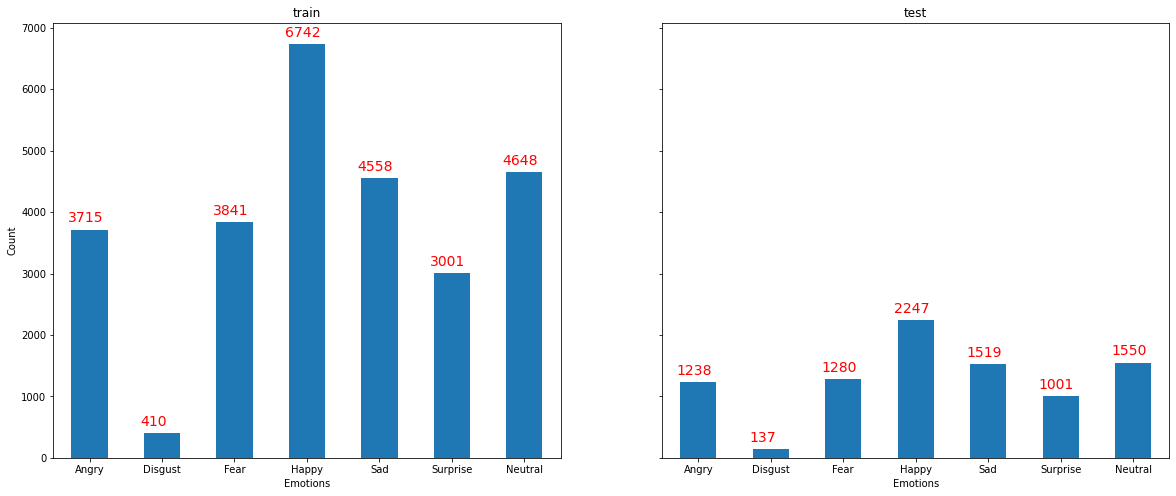

In [5]:
#SHOW DISTRIBUTION TRAIN/TEST

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_label_to_text = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Count")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
         axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='red',
                    rotation=0)

 
fig, axes = plt.subplots(1,2, figsize=(20,8), sharey=True)
setup_axe(axes[0],FER_training,'train')
setup_axe(axes[1],FER_testing,'test')
plt.show()

In [15]:
#Define Neural Network Variables

inputNeurals = 2304 #Image size 48x48
outputNeurals = 7 #by Each Class
quantityEpochs = 300 #Iteration Quantity
batchSize = 128
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100) # for OverFitting in Neural Networks

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']



In [7]:
# Standard Information

X_train,Y_train=[],[]
for index, row in FER_training.iterrows(): 
   val=row['pixel_values']
   X_train.append(np.array(val,'float32'))
   Y_train.append(row['emotion']) 


X_test, Y_test=[],[]
for index, row in FER_testing.iterrows(): 
   val=row['pixel_values']
   X_test.append(np.array(val,'float32'))
   Y_test.append(row['emotion'])


X_train = np.array(X_train).astype('float32') / 255.
X_train = X_train.reshape((len(X_train), inputNeurals)) 

X_test = np.array(X_test).astype('float32') / 255.
X_test = X_test.reshape((len(X_test), inputNeurals)) 

Y_train = np_utils.to_categorical(Y_train)
Y_test =np_utils.to_categorical(Y_test)


print('Training features shape ',X_train.shape)
print('Training labels shape',X_test.shape)
print('Testing features shape ',Y_train.shape)
print('Testing labels shape',Y_test.shape)

Training features shape  (26915, 2304)
Training labels shape (8972, 2304)
Testing features shape  (26915, 7)
Testing labels shape (8972, 7)


In [8]:
#Create First Neural Network with 1 hidden Layer

hiddenNeurals = 1024

model = Sequential()
model.add(Dense(hiddenNeurals, activation='sigmoid', input_shape=(inputNeurals,)))
model.add(Dropout(0.25)) #Evitar Overfitting
model.add(Dense(outputNeurals, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model, show_layer_names=True, show_shapes=True)

history = model.fit(X_train, Y_train, batch_size = batchSize, validation_data=(X_test, Y_test), epochs=quantityEpochs, verbose=0 )

print ('Trained Model')


Trained Model


Train Accuracy: 0.851, Test Accuracy: 0.435
Train Loss: 0.449, Test Loss: 2.367


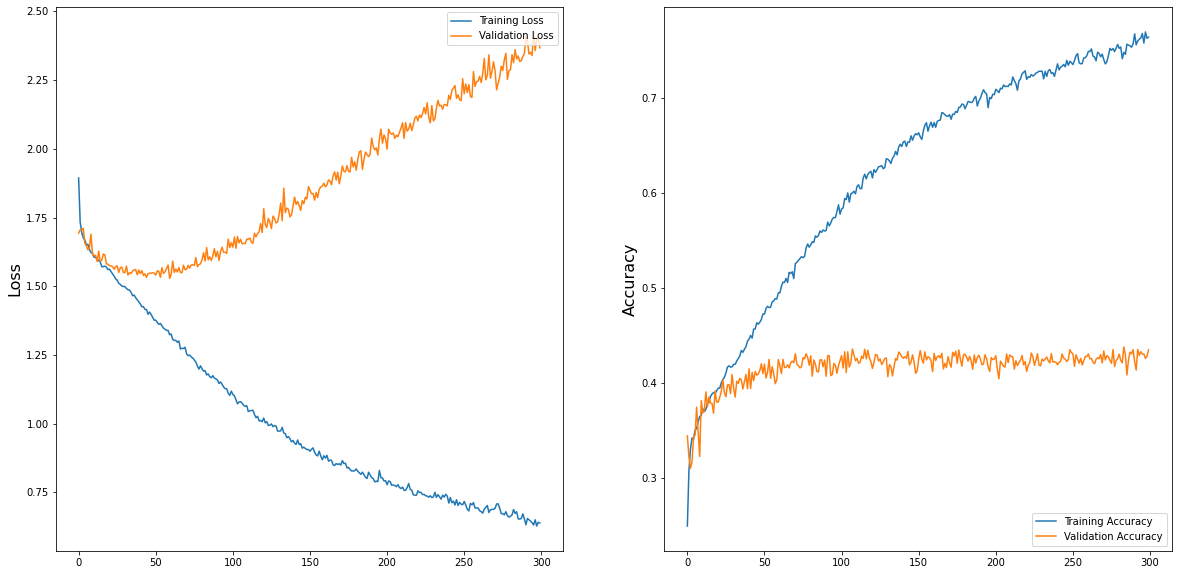

In [14]:
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))
# plot training history

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model Accuracy on Testing data: 0.4350
              precision    recall  f1-score   support

           0     0.3419    0.2472    0.2869      1238
           1     0.4167    0.2555    0.3167       137
           2     0.3333    0.2523    0.2872      1280
           3     0.5377    0.6564    0.5912      2247
           4     0.3811    0.2837    0.3253      1519
           5     0.5408    0.5964    0.5672      1001
           6     0.3597    0.4748    0.4093      1550

    accuracy                         0.4350      8972
   macro avg     0.4159    0.3952    0.3977      8972
weighted avg     0.4228    0.4350    0.4225      8972



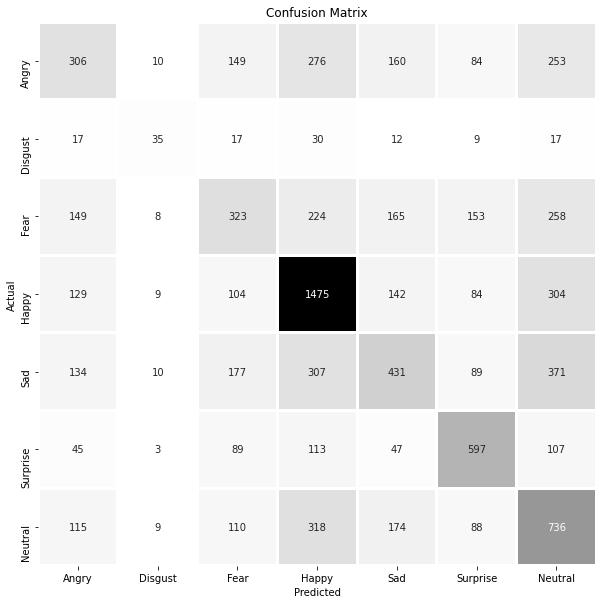

In [17]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)

print("Model Accuracy on Testing data: {:.4f}".format(accuracy_score(test_true, test_pred)))

# Predicted values
y_pred = test_pred

# Actual values
y_act = test_true 


cm = confusion_matrix(y_act, y_pred)
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = emotion_labels,
                     columns = emotion_labels
                    )

final_cm = cm_df

final_cm


# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=[0,1,2,3,4,5,6], digits = 4))

# Normalise
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(final_cm, annot=True, fmt='.2f',xticklabels=emotion_labels, yticklabels=emotion_labels)
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title ('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [18]:
#Create First Neural Network with 2 hidden Layer

firstHiddenNeurals = 1024
secondHiddenNeurals = 256

model2 = Sequential()
model2.add(Dense(firstHiddenNeurals, activation='sigmoid', input_shape=(inputNeurals,)))
model2.add(Dropout(0.25))
model2.add(Dense(secondHiddenNeurals, activation='sigmoid'))
model2.add(Dropout(0.5)) #Evitar Overfitting
model2.add(Dense(outputNeurals, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model2, show_layer_names=True, show_shapes=True)

history2 = model2.fit(X_train, Y_train, batch_size = batchSize, validation_data=(X_test, Y_test), epochs=quantityEpochs, verbose=0 )

print ('Trained Model')



Train Accuracy: 0.799, Test Accuracy: 0.439
Train Loss: 0.622, Test Loss: 1.861


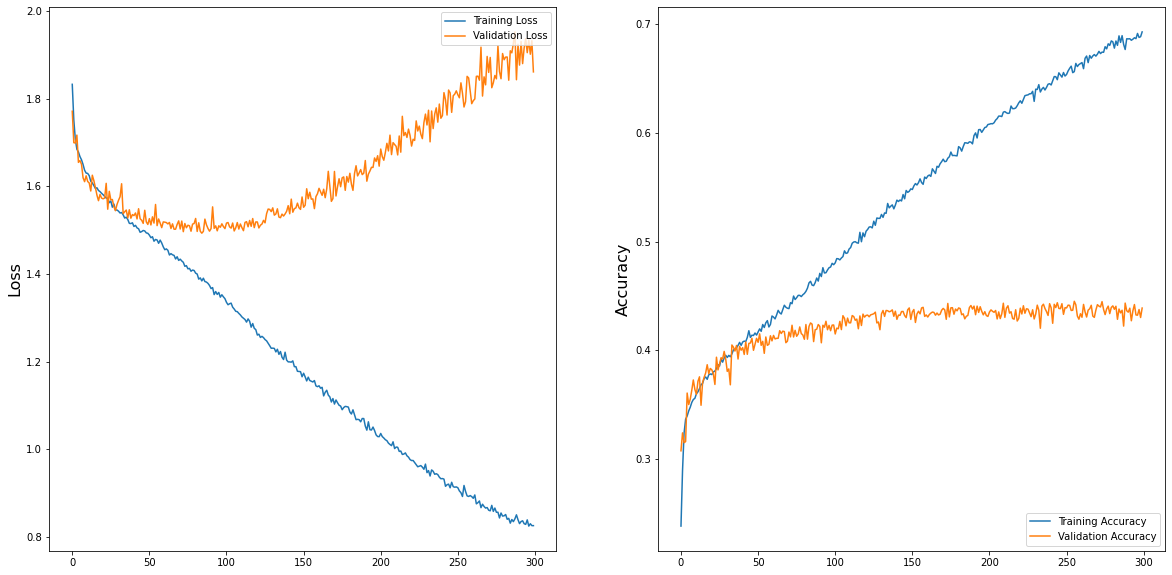

In [19]:
train_loss, train_acc = model2.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))
# plot training history

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model Accuracy on Testing data: 0.4389
              precision    recall  f1-score   support

           0     0.3348    0.3069    0.3203      1238
           1     0.4828    0.3066    0.3750       137
           2     0.3324    0.2852    0.3070      1280
           3     0.5811    0.6093    0.5948      2247
           4     0.3391    0.4128    0.3723      1519
           5     0.5420    0.6064    0.5724      1001
           6     0.4130    0.3535    0.3810      1550

    accuracy                         0.4389      8972
   macro avg     0.4322    0.4115    0.4175      8972
weighted avg     0.4357    0.4389    0.4354      8972



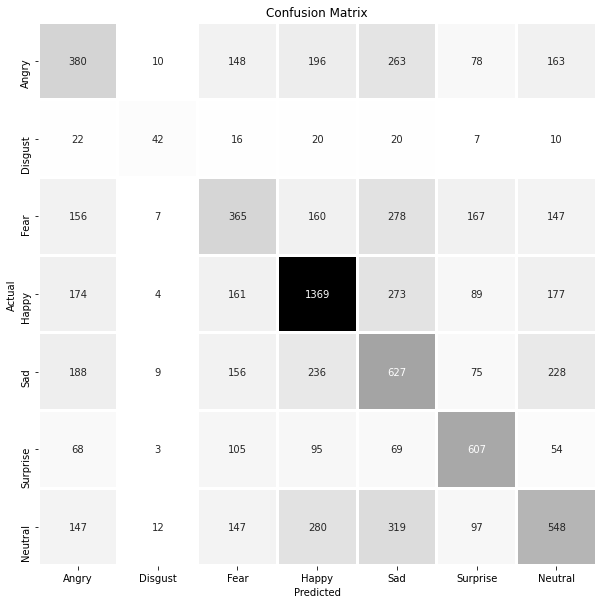

In [20]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model2.predict(X_test), axis=1)

print("Model Accuracy on Testing data: {:.4f}".format(accuracy_score(test_true, test_pred)))

# Predicted values
y_pred = test_pred

# Actual values
y_act = test_true 


cm = confusion_matrix(y_act, y_pred)
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = emotion_labels,
                     columns = emotion_labels
                    )

final_cm = cm_df

final_cm


# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=[0,1,2,3,4,5,6], digits = 4))

# Normalise
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(final_cm, annot=True, fmt='.2f',xticklabels=emotion_labels, yticklabels=emotion_labels)
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title ('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [21]:
#Create First Neural Network with 3 hidden Layer

firstHiddenNeurals = 1024
secondHiddenNeurals = 256
thirdHiddenNeurals = 64

model3 = Sequential()
model3.add(Dense(firstHiddenNeurals, activation='sigmoid', input_shape=(inputNeurals,)))
model3.add(Dropout(0.25))
model3.add(Dense(secondHiddenNeurals, activation='sigmoid'))
model3.add(Dropout(0.25)) #Evitar Overfitting
model3.add(Dense(thirdHiddenNeurals, activation='sigmoid'))
model3.add(Dropout(0.25)) #Evitar Overfitting
model3.add(Dense(outputNeurals, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model3, show_layer_names=True, show_shapes=True)

history3 = model3.fit(X_train, Y_train, batch_size = batchSize, validation_data=(X_test, Y_test), epochs=quantityEpochs, verbose=0 )

print ('Trained Model')

Trained Model


Train Accuracy: 0.741, Test Accuracy: 0.428
Train Loss: 0.734, Test Loss: 1.787


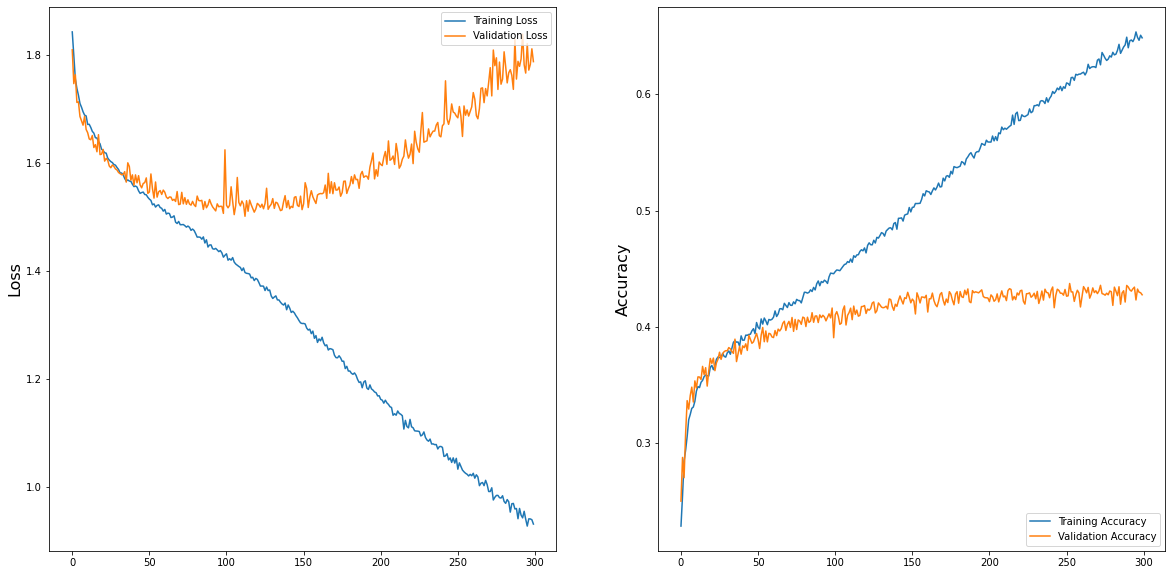

In [22]:
train_loss, train_acc = model3.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model3.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))
# plot training history

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model Accuracy on Testing data: 0.4278
              precision    recall  f1-score   support

           0     0.3309    0.2609    0.2918      1238
           1     0.7200    0.1314    0.2222       137
           2     0.3175    0.2711    0.2925      1280
           3     0.5868    0.6017    0.5942      2247
           4     0.3083    0.4292    0.3588      1519
           5     0.6798    0.4985    0.5752      1001
           6     0.3751    0.4174    0.3951      1550

    accuracy                         0.4278      8972
   macro avg     0.4741    0.3729    0.3900      8972
weighted avg     0.4418    0.4278    0.4274      8972



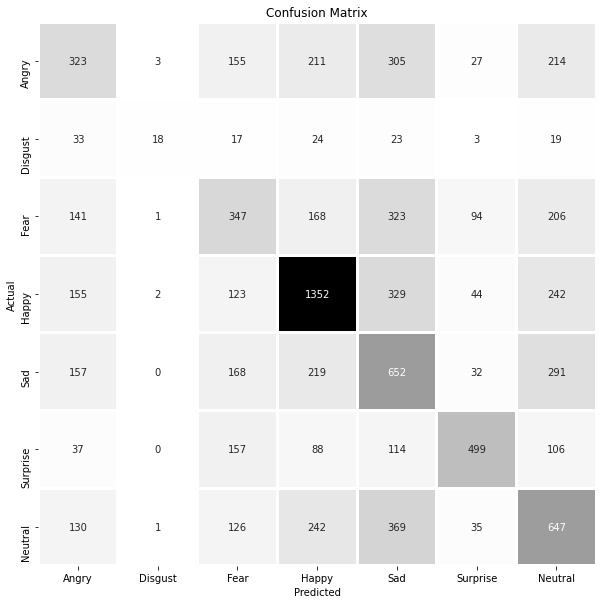

In [23]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model3.predict(X_test), axis=1)

print("Model Accuracy on Testing data: {:.4f}".format(accuracy_score(test_true, test_pred)))

# Predicted values
y_pred = test_pred

# Actual values
y_act = test_true 


cm = confusion_matrix(y_act, y_pred)
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = emotion_labels,
                     columns = emotion_labels
                    )

final_cm = cm_df

final_cm


# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=[0,1,2,3,4,5,6], digits = 4))

# Normalise
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(final_cm, annot=True, fmt='.2f',xticklabels=emotion_labels, yticklabels=emotion_labels)
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title ('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [24]:
#Create First Neural Network with 4 hidden Layer

firstHiddenNeurals = 1024
secondHiddenNeurals = 256
thirdHiddenNeurals = 64
fourthHiddenNeurals = 32

model4 = Sequential()
model4.add(Dense(firstHiddenNeurals, activation='sigmoid', input_shape=(inputNeurals,)))
model4.add(Dropout(0.25))
model4.add(Dense(secondHiddenNeurals, activation='sigmoid'))
model4.add(Dropout(0.25)) #Evitar Overfitting
model4.add(Dense(thirdHiddenNeurals, activation='sigmoid'))
model4.add(Dropout(0.25)) #Evitar Overfitting
model4.add(Dense(fourthHiddenNeurals, activation='sigmoid'))
#model4.add(Dropout(0.25)) #Evitar Overfitting
model4.add(Dense(outputNeurals, activation='softmax'))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model4, show_layer_names=True, show_shapes=True)

history4 = model4.fit(X_train, Y_train, batch_size = batchSize, validation_data=(X_test, Y_test), epochs=quantityEpochs, verbose=0 )

print ('Trained Model')


Trained Model


Train Accuracy: 0.702, Test Accuracy: 0.429
Train Loss: 0.816, Test Loss: 1.755


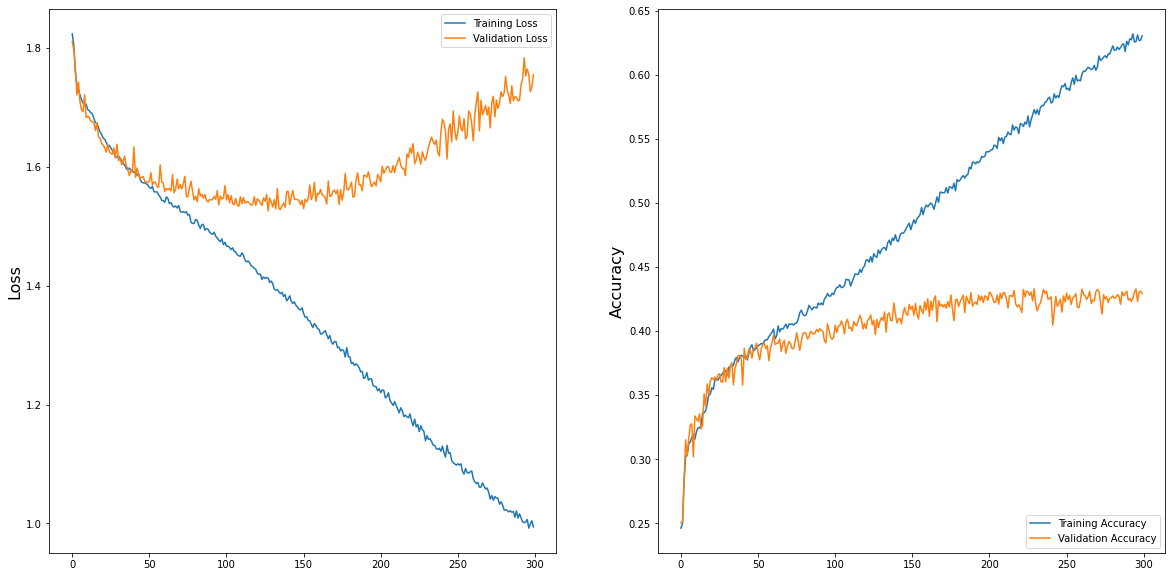

In [25]:
train_loss, train_acc = model4.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model4.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))
# plot training history

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model Accuracy on Testing data: 0.4293
              precision    recall  f1-score   support

           0     0.3078    0.2851    0.2960      1238
           1     0.4571    0.1168    0.1860       137
           2     0.3114    0.2148    0.2543      1280
           3     0.4814    0.7481    0.5858      2247
           4     0.4032    0.2482    0.3073      1519
           5     0.6721    0.4935    0.5691      1001
           6     0.3759    0.4232    0.3982      1550

    accuracy                         0.4293      8972
   macro avg     0.4299    0.3614    0.3710      8972
weighted avg     0.4226    0.4293    0.4110      8972



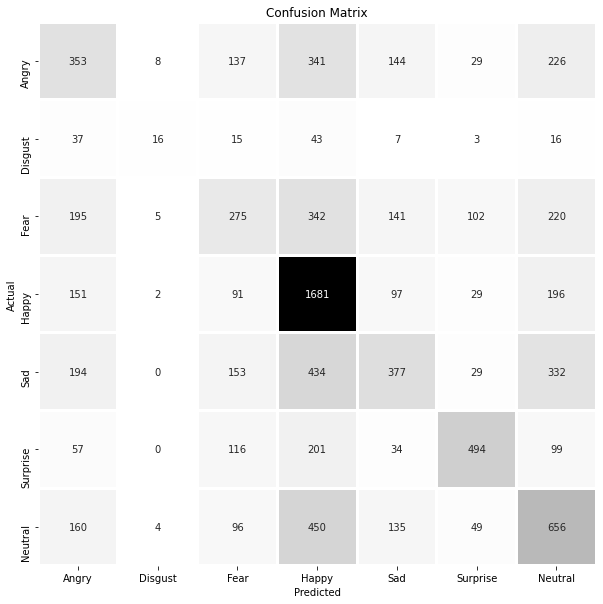

In [26]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model4.predict(X_test), axis=1)

print("Model Accuracy on Testing data: {:.4f}".format(accuracy_score(test_true, test_pred)))

# Predicted values
y_pred = test_pred

# Actual values
y_act = test_true 


cm = confusion_matrix(y_act, y_pred)
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = emotion_labels,
                     columns = emotion_labels
                    )

final_cm = cm_df

final_cm


# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=[0,1,2,3,4,5,6], digits = 4))

# Normalise
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(final_cm, annot=True, fmt='.2f',xticklabels=emotion_labels, yticklabels=emotion_labels)
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title ('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [39]:
#Comparative Loss and Accuracy between Models

train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy 1C: %.3f, Test Accuracy 1C: %.3f' % (train_acc, test_acc))
print('Train Loss 1C: %.3f, Test Loss 1C: %.3f' % (train_loss, test_loss))

train_loss, train_acc = model2.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model2.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy 2C: %.3f, Test Accuracy 2C: %.3f' % (train_acc, test_acc))
print('Train Loss 2C: %.3f, Test Loss2 C: %.3f' % (train_loss, test_loss))

train_loss, train_acc = model3.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model3.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy 3C: %.3f, Test Accuracy 3C: %.3f' % (train_acc, test_acc))
print('Train Loss 3C: %.3f, Test Loss 3C: %.3f' % (train_loss, test_loss))

train_loss, train_acc = model4.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model4.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy 4C: %.3f, Test Accuracy 4C: %.3f' % (train_acc, test_acc))
print('Train Loss 4C: %.3f, Test Loss 4C: %.3f' % (train_loss, test_loss))

Train Accuracy 1C: 0.851, Test Accuracy 1C: 0.435
Train Loss 1C: 0.449, Test Loss 1C: 2.367
Train Accuracy 2C: 0.799, Test Accuracy 2C: 0.439
Train Loss 2C: 0.622, Test Loss2 C: 1.861
Train Accuracy 3C: 0.741, Test Accuracy 3C: 0.428
Train Loss 3C: 0.734, Test Loss 3C: 1.787
Train Accuracy 4C: 0.702, Test Accuracy 4C: 0.429
Train Loss 4C: 0.816, Test Loss 4C: 1.755


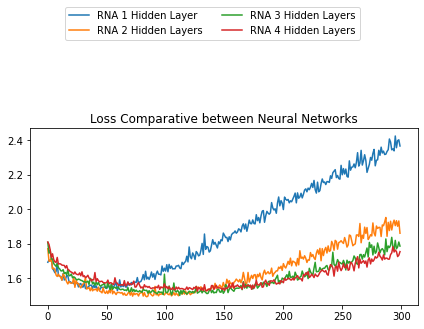

In [37]:
# plot comparativa Loss
plt.plot(history.history['val_loss'], label='RNA 1 Hidden Layer')
plt.plot(history2.history['val_loss'], label='RNA 2 Hidden Layers')
plt.plot(history3.history['val_loss'], label='RNA 3 Hidden Layers')
plt.plot(history4.history['val_loss'], label='RNA 4 Hidden Layers')
plt.legend(loc='lower center',bbox_to_anchor=(0.5, 1.0),ncol=2, bbox_transform=plt.gcf().transFigure)
plt.title("Loss Comparative between Neural Networks")
plt.tight_layout()
plt.show()

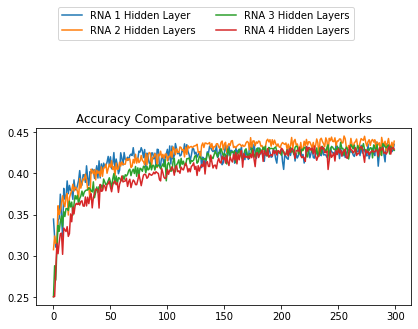

In [38]:
# plot comparativa Accuracy
plt.plot(history.history['val_accuracy'], label='RNA 1 Hidden Layer')
plt.plot(history2.history['val_accuracy'], label='RNA 2 Hidden Layers')
plt.plot(history3.history['val_accuracy'], label='RNA 3 Hidden Layers')
plt.plot(history4.history['val_accuracy'], label='RNA 4 Hidden Layers')
plt.legend(loc='lower center',bbox_to_anchor=(0.5, 1.0),ncol=2, bbox_transform=plt.gcf().transFigure)
plt.title("Accuracy Comparative between Neural Networks")
plt.tight_layout()
plt.show()

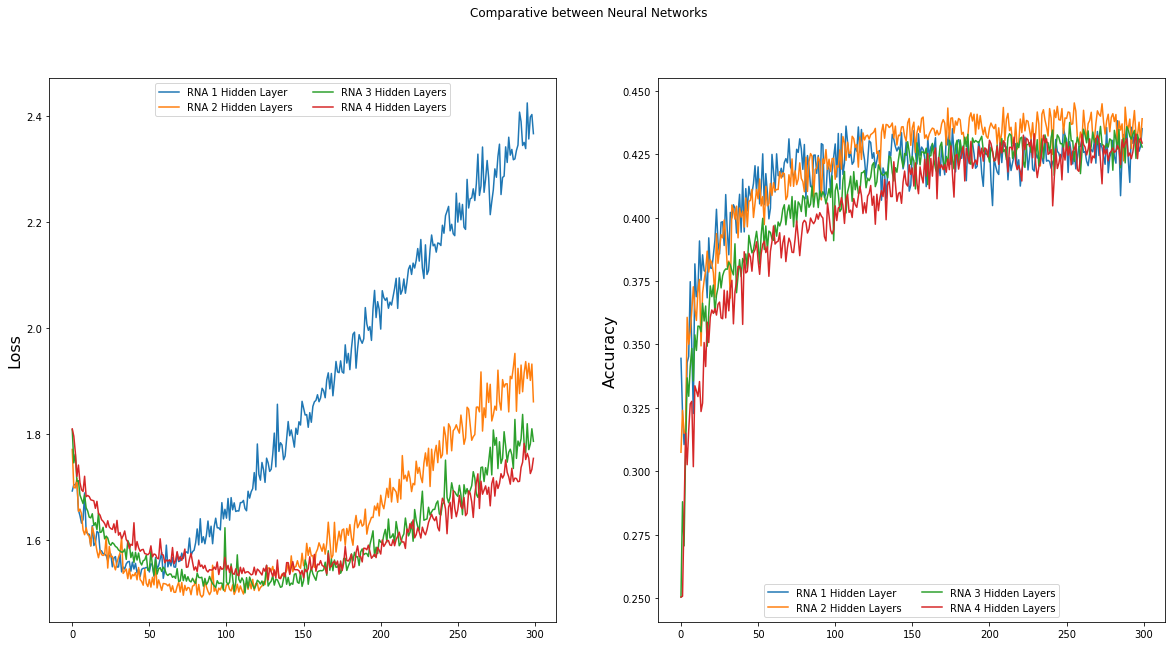

In [35]:
# plot training history

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['val_loss'], label='RNA 1 Hidden Layer')
plt.plot(history2.history['val_loss'], label='RNA 2 Hidden Layers')
plt.plot(history3.history['val_loss'], label='RNA 3 Hidden Layers')
plt.plot(history4.history['val_loss'], label='RNA 4 Hidden Layers')
plt.legend(loc='upper center',ncol=2)

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['val_accuracy'], label='RNA 1 Hidden Layer')
plt.plot(history2.history['val_accuracy'], label='RNA 2 Hidden Layers')
plt.plot(history3.history['val_accuracy'], label='RNA 3 Hidden Layers')
plt.plot(history4.history['val_accuracy'], label='RNA 4 Hidden Layers')
plt.legend(loc='lower center',ncol=2)

plt.suptitle("Comparative between Neural Networks")
plt.show()

In [40]:
#BONUS TRACK CONVOLUTIONAL NEURAL NETWORK

# Normalizamos la Información


features,labels=[],[]
for index, row in FER_training.iterrows(): 
   val=row['pixel_values']
   features.append(np.array(val,'float32'))
   labels.append(row['emotion']) 


test_features, labels_testing=[],[]
for index, row in FER_testing.iterrows(): 
   val=row['pixel_values']
   test_features.append(np.array(val,'float32'))
   labels_testing.append(row['emotion']) 


CNN_features = np.array(features).reshape(-1,48,48,1)
CNN_test_features = np.array(test_features).reshape(-1,48,48,1)

CNN_features = CNN_features/255
CNN_test_features = CNN_test_features/255

CNN_labels = np_utils.to_categorical(labels)
CNN_labels_testing =np_utils.to_categorical(labels_testing)



In [46]:
modelCNN = Sequential()

#1st CNN layer
modelCNN.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
modelCNN.add(BatchNormalization())
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size = (2,2)))
modelCNN.add(Dropout(0.25))

#2nd CNN layer
modelCNN.add(Conv2D(128,(5,5),padding = 'same'))
modelCNN.add(BatchNormalization())
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size = (2,2)))
modelCNN.add(Dropout (0.25))

#3rd CNN layer
modelCNN.add(Conv2D(512,(3,3),padding = 'same'))
modelCNN.add(BatchNormalization())
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size = (2,2)))
modelCNN.add(Dropout (0.25))

#4th CNN layer
modelCNN.add(Conv2D(512,(3,3), padding='same'))
modelCNN.add(BatchNormalization())
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.25))

modelCNN.add(Flatten())

#Fully connected 1st layer
modelCNN.add(Dense(256))
modelCNN.add(BatchNormalization())
modelCNN.add(Activation('relu'))
modelCNN.add(Dropout(0.25))


# Fully connected layer 2nd layer
modelCNN.add(Dense(512))
modelCNN.add(BatchNormalization())
modelCNN.add(Activation('relu'))
modelCNN.add(Dropout(0.25))

modelCNN.add(Dense(7, activation='softmax'))



opt = Adam(lr = 0.0001)
modelCNN.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:

# lleva a cabo el entrenamiento

quantityEpochs = 50

historyCNN = modelCNN.fit(x=CNN_features, 
            y=CNN_labels, 
            batch_size=batchSize,
            epochs=quantityEpochs,
            verbose=0,
            validation_data=(CNN_test_features,CNN_labels_testing))



Train Accuracy: 0.893, Test Accuracy: 0.638
Train Loss: 0.356, Test Loss: 1.049


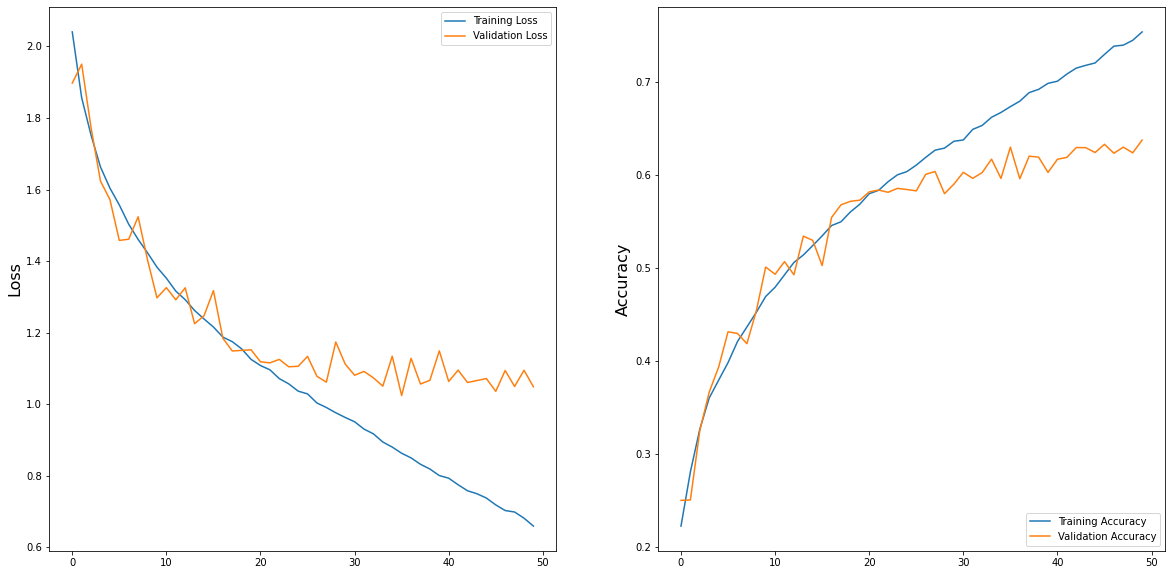

In [44]:
train_loss, train_acc = modelCNN.evaluate(CNN_features,CNN_labels, verbose=0)
test_loss, test_acc = modelCNN.evaluate(CNN_test_features, CNN_labels_testing, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))
# plot training history

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(historyCNN.history['loss'], label='Training Loss')
plt.plot(historyCNN.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(historyCNN.history['accuracy'], label='Training Accuracy')
plt.plot(historyCNN.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [47]:
# lleva a cabo el entrenamiento

quantityEpochs = 300

historyCNN_300 = modelCNN.fit(x=CNN_features, 
            y=CNN_labels, 
            batch_size=batchSize,
            epochs=quantityEpochs,
            verbose=0,
            validation_data=(CNN_test_features,CNN_labels_testing))

print ('Trained Model')

Trained Model


Train Accuracy: 0.998, Test Accuracy: 0.647
Train Loss: 0.004, Test Loss: 2.215


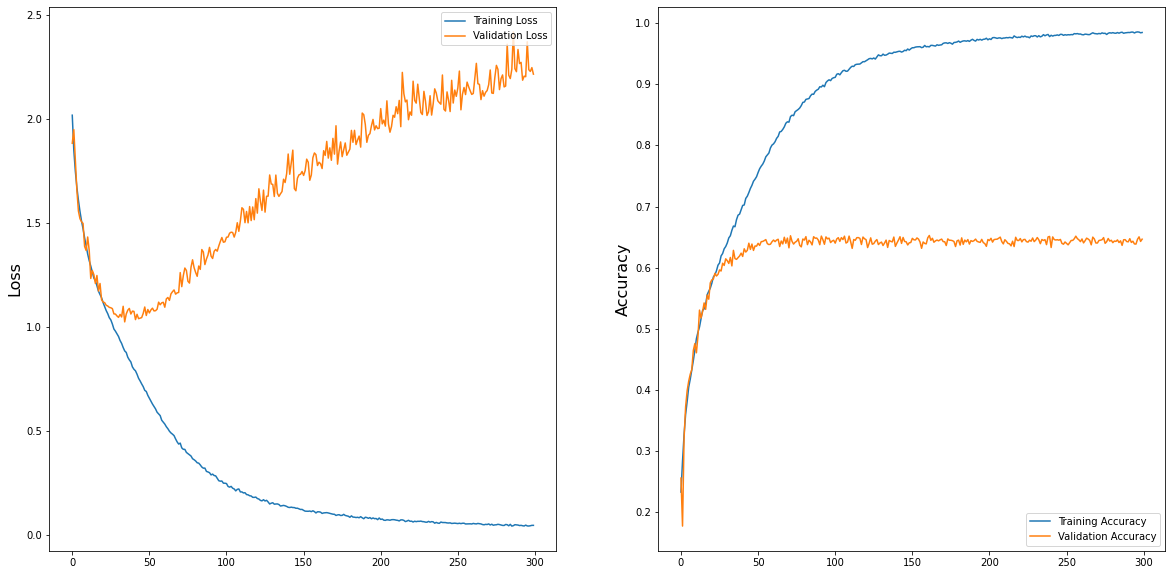

In [49]:
train_loss, train_acc = modelCNN.evaluate(CNN_features,CNN_labels, verbose=0)
test_loss, test_acc = modelCNN.evaluate(CNN_test_features, CNN_labels_testing, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))
# plot training history

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Loss', fontsize=16)
plt.plot(historyCNN_300.history['loss'], label='Training Loss')
plt.plot(historyCNN_300.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(historyCNN_300.history['accuracy'], label='Training Accuracy')
plt.plot(historyCNN_300.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model Accuracy on Testing data: 0.6467
              precision    recall  f1-score   support

           0     0.5694    0.5105    0.5383      1238
           1     0.8085    0.5547    0.6580       137
           2     0.5264    0.4898    0.5075      1280
           3     0.8157    0.8393    0.8274      2247
           4     0.5158    0.5589    0.5365      1519
           5     0.7416    0.7912    0.7656      1001
           6     0.6061    0.6065    0.6063      1550

    accuracy                         0.6467      8972
   macro avg     0.6548    0.6216    0.6342      8972
weighted avg     0.6451    0.6467    0.6449      8972



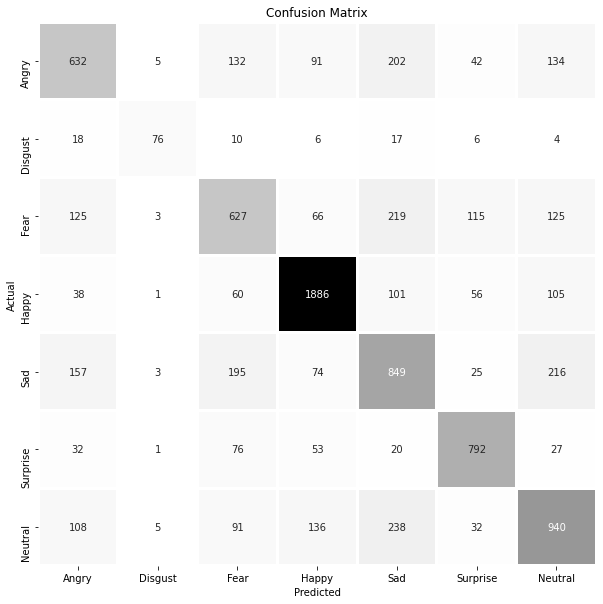

In [50]:
test_true = np.argmax(CNN_labels_testing, axis=1)
test_pred = np.argmax(modelCNN.predict(CNN_test_features), axis=1)
print("Model Accuracy on Testing data: {:.4f}".format(accuracy_score(test_true, test_pred)))

# Predicted values
y_pred = test_pred

# Actual values
y_act = test_true 


cm = confusion_matrix(y_act, y_pred)
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = emotion_labels,
                     columns = emotion_labels
                    )

final_cm = cm_df

final_cm


# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=[0,1,2,3,4,5,6], digits = 4))

# Normalise
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(final_cm, annot=True, fmt='.2f',xticklabels=emotion_labels, yticklabels=emotion_labels)
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title ('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

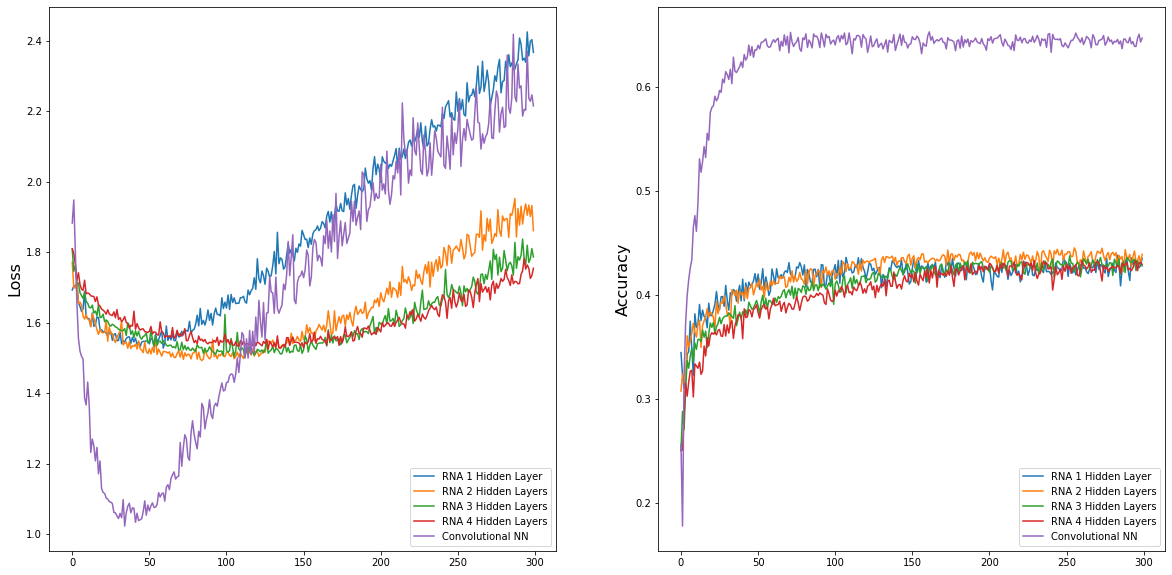

In [52]:
# plot comparativa Convolutional Neural Network

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['val_loss'], label='RNA 1 Hidden Layer')
plt.plot(history2.history['val_loss'], label='RNA 2 Hidden Layers')
plt.plot(history3.history['val_loss'], label='RNA 3 Hidden Layers')
plt.plot(history4.history['val_loss'], label='RNA 4 Hidden Layers')
plt.plot(historyCNN_300.history['val_loss'], label='Convolutional NN')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['val_accuracy'], label='RNA 1 Hidden Layer')
plt.plot(history2.history['val_accuracy'], label='RNA 2 Hidden Layers')
plt.plot(history3.history['val_accuracy'], label='RNA 3 Hidden Layers')
plt.plot(history4.history['val_accuracy'], label='RNA 4 Hidden Layers')
plt.plot(historyCNN_300.history['val_accuracy'], label='Convolutional NN')
plt.legend(loc='lower right')
plt.show()


In [53]:
#Study Cases

def show_image(pic):
    photo = path + "/validateImages/" + pic
    show_img=image.load_img(photo, target_size=(200, 200))
    plt.gray()
    plt.imshow(show_img)
    plt.show() 


def predict_image(pic, model):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    photo = path + "/validateImages/" + pic
    img = image.load_img(photo, color_mode= "grayscale", target_size=(48, 48))
    x = image.img_to_array(img)

    if model == modelCNN :
      x_pred = np.array(x).astype('float32') / 255.
      x_pred = x_pred.reshape(-1,48,48,1)
      custom = model.predict(x_pred)
    else:
      x_pred = np.array(x).astype('float32') / 255.
      x_pred = x_pred.reshape(1,2304)
      custom = model.predict(x_pred)
    
    m=0.000000000000000000001
    a=custom[0]
    for i in range(0,len(a)):
        if a[i]>m:
            m=a[i]
            ind=i
        
    print('Expression Prediction:',emotion_labels[ind])


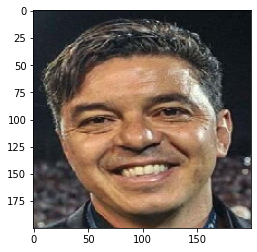

Expression Prediction: Happy
Expression Prediction: Happy
Expression Prediction: Angry
Expression Prediction: Happy
Expression Prediction: Happy


In [54]:
show_image('Gallardo.png')
predict_image('Gallardo.png', model)
predict_image('Gallardo.png', model2)
predict_image('Gallardo.png', model3)
predict_image('Gallardo.png', model4)
predict_image('Gallardo.png', modelCNN)

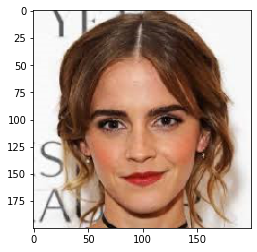

Expression Prediction: Sad
Expression Prediction: Neutral
Expression Prediction: Happy
Expression Prediction: Happy
Expression Prediction: Sad


In [55]:
show_image('Emma.jpg')
predict_image('Emma.jpg', model)
predict_image('Emma.jpg', model2)
predict_image('Emma.jpg', model3)
predict_image('Emma.jpg', model4)
predict_image('Emma.jpg', modelCNN)

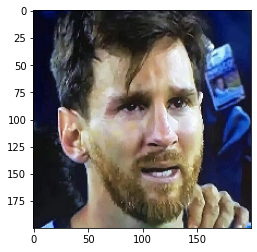

Expression Prediction: Fear
Expression Prediction: Angry
Expression Prediction: Sad
Expression Prediction: Neutral
Expression Prediction: Neutral


In [56]:
show_image('Messi.jpg')
predict_image('Messi.jpg', model)
predict_image('Messi.jpg', model2)
predict_image('Messi.jpg', model3)
predict_image('Messi.jpg', model4)
predict_image('Messi.jpg', modelCNN)

In [59]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
model.save(path + "/models/facialExpression_1LH.h5")
model2.save(path + "/models/facialExpression_2LH.h5")
model3.save(path + "/models/facialExpression_3LH.h5")
model4.save(path + "/models/facialExpression_4LH.h5")
modelCNN.save(path + "/models/facialExpression_CNN.h5")